In [20]:
from keras.datasets.mnist import load_data
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from matplotlib import pyplot as plt

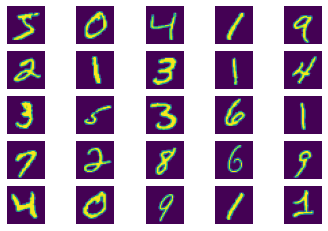

In [21]:
(trainX, trainy), (testX, testy) = load_data()

for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [22]:
from tensorflow.keras.layers import Input, Embedding, Dense, Reshape, Concatenate, Conv2DTranspose, LeakyReLU

def enhance_generator(latent_dim, n_classes=10):
    # Label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    
    # Linear multiplication
    n_nodes = 128 * 7 * 7  # Adjusted to match later concatenation
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 128))(li)
    
    # Image generator input
    in_lat = Input(shape=(latent_dim,))
    
    # Foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    
    # Merge image gen and label input
    merge = Concatenate()([gen, li])
    
    # Upsample to 14x14
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # Upsample to 28x28 (matching MNIST image size)
    gen = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='tanh')(gen)
    
    # Define model
    model = Model([in_lat, in_label], gen)
    
    return model


In [23]:
def enhance_discriminator(in_shape=(28, 28, 1), n_classes=10):
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 100)(in_label)

    n_nodes = in_shape[0] * in_shape[1] * in_shape[2]
    li = Dense(n_nodes)(li)
    li = Reshape(in_shape)(li)

    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])

    fe = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(merge)  # Increase filters
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(fe)  # Increase filters
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)

    out_layer = Dense(1, activation='sigmoid')(fe)

    model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [24]:
def define_gan(g_model, d_model):
	d_model.trainable = False  
	gen_noise, gen_label = g_model.input  
	gen_output = g_model.output  #32x32x3
    
	
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [25]:
def load_real_samples():
	
	(trainX, trainy), (_, _) = load_data()  #mnist
	X = trainX.astype('float32')
	
	X = (X - 127.5) / 127.5   
	return [X, trainy]


In [26]:
def generate_real_samples(dataset, n_samples):
	
	images, labels = dataset  
	
	ix = randint(0, images.shape[0], n_samples)
	
	X, labels = images[ix], labels[ix]
	
	y = ones((n_samples, 1))  
	return [X, labels], y

In [37]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)

	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [38]:
def generate_fake_samples(generator, latent_dim, n_samples):
	
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1)) 
	return [images, labels_input], y

In [29]:
global d;d=[]
global d2;d2=[]

In [30]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
	for i in range(n_epochs):
		
		
		for j in range(bat_per_epo):
			
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

           
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
           
			y_gan = ones((n_batch, 1))
            
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
			d.append(d_loss_real)
			d2.append(g_loss)
		g_model.save('mnist_conditional_generator3_epochs.h5')

In [31]:
latent_dim = 100
# create the discriminator

d_model = enhance_discriminator()
# create the generator
g_model = enhance_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2)

c:\Users\dhruv\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 13ms/step
Epoch>1, Batch1/468, d1=0.713, d2=0.696 g=0.691
2/2 [==============================] - 0s 10ms/step
Epoch>1, Batch2/468, d1=0.547, d2=0.699 g=0.687
2/2 [==============================] - 0s 15ms/step
Epoch>1, Batch3/468, d1=0.422, d2=0.706 g=0.681
2/2 [==============================] - 0s 10ms/step
Epoch>1, Batch4/468, d1=0.305, d2=0.718 g=0.670
2/2 [==============================] - 0s 12ms/step
Epoch>1, Batch5/468, d1=0.218, d2=0.735 g=0.654
2/2 [==============================] - 0s 12ms/step
Epoch>1, Batch6/468, d1=0.149, d2=0.758 g=0.637
2/2 [==============================] - 0s 15ms/step
Epoch>1, Batch7/468, d1=0.110, d2=0.783 g=0.620
2/2 [==============================] - 0s 14ms/step
Epoch>1, Batch8/468, d1=0.086, d2=0.806 g=0.605
2/2 [==============================] - 0s 14ms/step
Epoch>1, Batch9/468, d1=0.075, d2=0.822 g=0.595
2/2 [==============================] - 0s 13ms/step
Epoch>1, Batch10/468, d1=0.071, d2=0.835 g=0.590

In [32]:
print(d,d2)

[0.7133663296699524, 0.5474954843521118, 0.422049880027771, 0.30537134408950806, 0.217559814453125, 0.14931192994117737, 0.11019966006278992, 0.08609482645988464, 0.07530757784843445, 0.0709296464920044, 0.07226911932229996, 0.0800890177488327, 0.08956998586654663, 0.09358733892440796, 0.10061571002006531, 0.1086672693490982, 0.12165676057338715, 0.11554186046123505, 0.11121238768100739, 0.1240236759185791, 0.10820985585451126, 0.09889090806245804, 0.08681407570838928, 0.11215758323669434, 0.08114594221115112, 0.06738614290952682, 0.06780121475458145, 0.05239832401275635, 0.039287321269512177, 0.03972134739160538, 0.03407466039061546, 0.03658784180879593, 0.02773146890103817, 0.030824122950434685, 0.020098064094781876, 0.024247922003269196, 0.01717151701450348, 0.015520002692937851, 0.015786681324243546, 0.015659641474485397, 0.015384849160909653, 0.015939753502607346, 0.01591506600379944, 0.01922108605504036, 0.026792608201503754, 0.029265839606523514, 0.02307981811463833, 0.048502817

In [33]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
# 

In [34]:
model = load_model(r"C:\Users\dhruv\Downloads\GAN_MNIST\mnist_conditional_generator3_epochs.h5")

4/4 [==============================] - 0s 9ms/step


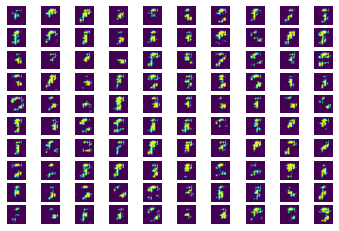

In [35]:
latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()
    
show_plot(X, 10)

In [40]:
#save the h5 file of the model.
model_json = g_model.to_json()
with open("generator2.json", "w") as json_file:
    json_file.write(model_json)
g_model.save_weights('weights2.h5')
g_model.save('model2.h5')
g_model.save(r"C:\Users\dhruv\OneDrive\Desktop\images\model3.h5")

1/1 [==============================] - 0s 93ms/step


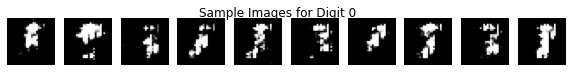

1/1 [==============================] - 0s 20ms/step


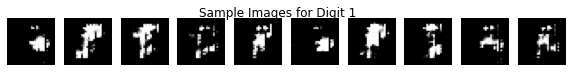

1/1 [==============================] - 0s 32ms/step


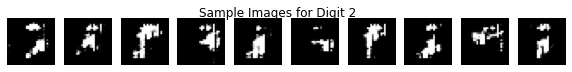

1/1 [==============================] - 0s 31ms/step


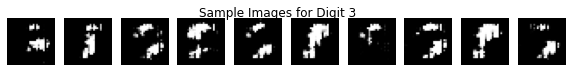

1/1 [==============================] - 0s 24ms/step


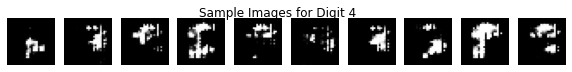

1/1 [==============================] - 0s 29ms/step


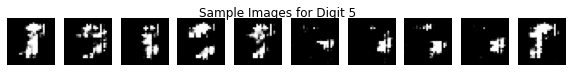

1/1 [==============================] - 0s 25ms/step


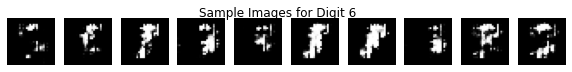

1/1 [==============================] - 0s 24ms/step


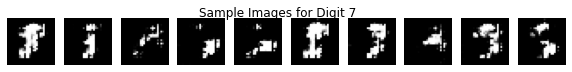

1/1 [==============================] - 0s 32ms/step


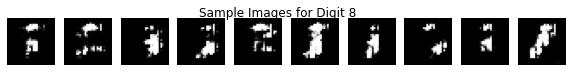

1/1 [==============================] - 0s 30ms/step


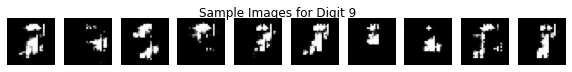

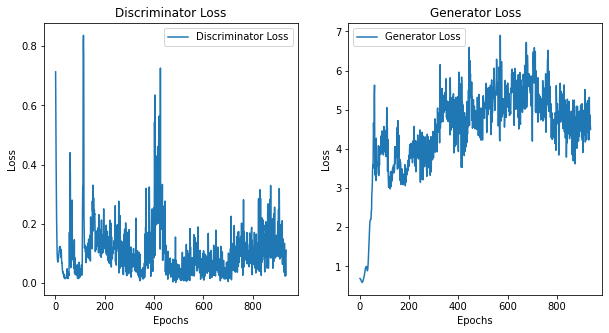

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load the trained generator model
generator = load_model(r"C:\Users\dhruv\Downloads\GAN_MNIST\mnist_conditional_generator3_epochs.h5")

# Generate and plot sample images for each digit (0-9)
latent_dim = 100
n_samples_per_digit = 10

for digit in range(10):
    labels = np.full((n_samples_per_digit, 1), digit)
    latent_points = np.random.randn(n_samples_per_digit, latent_dim)
    generated_images = generator.predict([latent_points, labels])
    
    plt.figure(figsize=(10, 1))
    for i in range(n_samples_per_digit):
        plt.subplot(1, n_samples_per_digit, i + 1)
        plt.axis('off')
        plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')

    plt.suptitle(f'Sample Images for Digit {digit}')
    plt.show()


discriminator_loss = d 
generator_loss = d2  
epochs = range(1, len(discriminator_loss) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, discriminator_loss, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, generator_loss, label='Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
